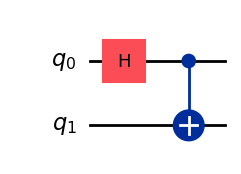

In [1]:
from qiskit import QuantumCircuit

# 2 qubits = 4 hidden states
initial_state = QuantumCircuit(2, name='Initial_State')
initial_state.h(0)
initial_state.cx(0,1)
initial_state.draw('mpl')

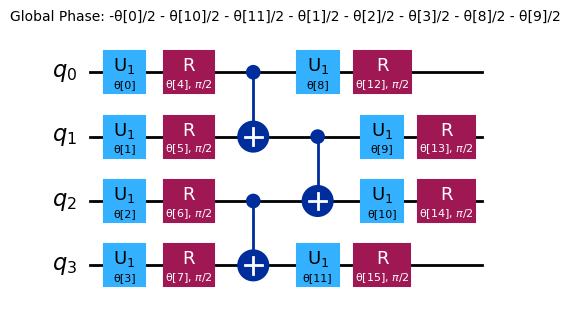

In [2]:
from qiskit.circuit.library import real_amplitudes, efficient_su2

#ansatz = real_amplitudes(3, reps=1)
ansatz = efficient_su2(4, reps=1, entanglement='pairwise', su2_gates=['rz','ry'])
ansatz.decompose(reps=1).draw('mpl')

In [26]:
from HMM.utils.qhmm_utils import aer_simulator_result_getter
from HMM import QHMM
import numpy as np

rg = aer_simulator_result_getter
# Training Hyperparameters
sequence_length = 10
tol = 1e-6
max_iter = 100
num_parameters = ansatz.num_parameters

theta_gen = [np.random.uniform(-2*np.pi,  2*np.pi) for _ in range(num_parameters)]

generating_model = QHMM(result_getter=rg,
                            initial_state=initial_state,
                            ansatz=ansatz,
                            theta=theta_gen)

## Maximum circuit depth estimation

The limiting hardware factor determining the length of QHMM we can perform is the T2 decoherence time of the latent state register. The motivation for using a QHMM is the added expressivity we can get from the off diagonal density matrix elements of the latent state. These elements decay by a factor of 1/e in time = T2. QHMM are particularly troublesome for quantum hardware implementation because the latent state register must remain coherent without decoupling or initialization for the entire course of the algorithm.

For a rough estimate of the maximum circuit depth we can execute such that the latent state remains coherent, we see how many times we can implement the unitary ansatz for each time step before the off diagonal latent states collapse:

In [3]:
from qiskit_ibm_runtime.fake_provider import FakeTorino

backend = FakeTorino()

In [29]:
from qiskit import transpile

ansatz_depth = transpile(ansatz, backend=backend).depth()
print('single time step depth: ', ansatz_depth)
backend_t2 = 126.55e-6
backend_clops = 210e3

num_time_steps = backend_clops*backend_t2/ansatz_depth

print('Maximum number of coherent time steps: ', num_time_steps)

single time step depth:  17
Maximum number of coherent time steps:  1.563264705882353


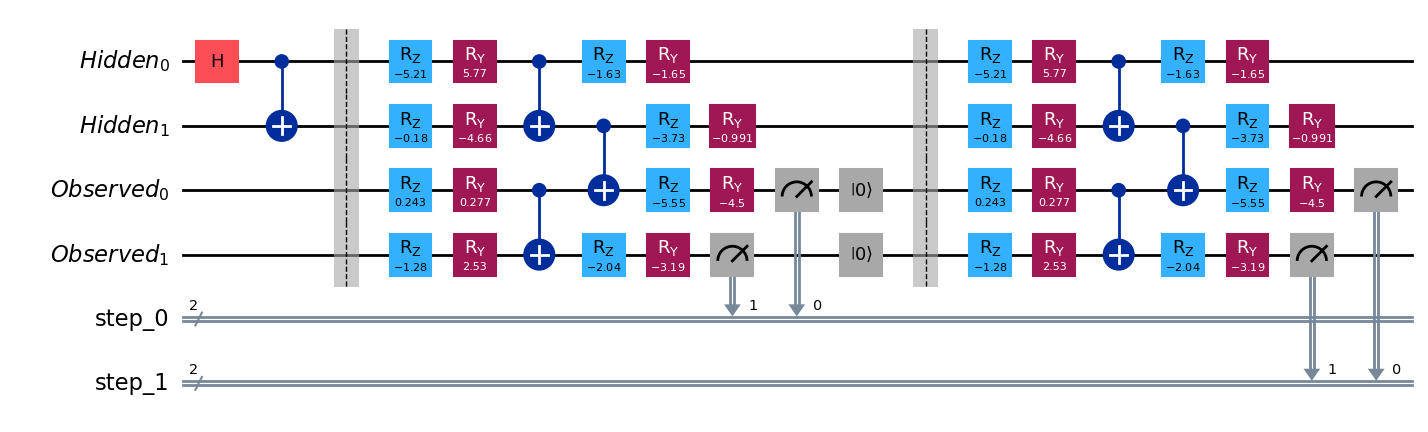

In [31]:
circ = generating_model.construct_circuit(2)
circ.decompose(reps=1).draw('mpl')

In [38]:
raw_counts = {'11 01': 65, '01 00': 25, '01 01': 288, '11 10': 24, '00 10': 62, '01 10': 82, '00 01': 176, '10 01': 98, '00 00': 73, '01 11': 32, '11 00': 20, '10 10': 22, '00 11': 10, '11 11': 8, '10 00': 5, '10 11': 10}
sorted_counts = {str(format(i, '02b')) : {} for i in range(4)}
for key in raw_counts.keys():
    steps = key.split(' ')
    sorted_counts[steps[1]][steps[0]] = raw_counts[key]

print(sorted_counts)

{'00': {'01': 25, '00': 73, '11': 20, '10': 5}, '01': {'11': 65, '01': 288, '00': 176, '10': 98}, '10': {'11': 24, '00': 62, '01': 82, '10': 22}, '11': {'01': 32, '00': 10, '11': 8, '10': 10}}


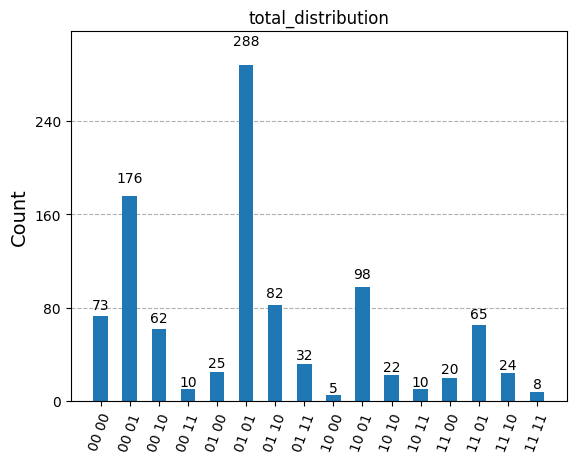

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram(raw_counts,
                title = 'total_distribution')

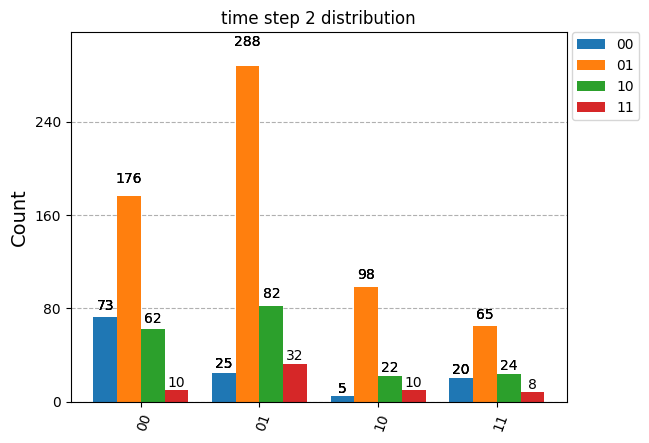

In [42]:
plot_histogram([sorted_counts['00'], sorted_counts['01'], sorted_counts['10'], sorted_counts['11']],
                legend=['00', '01', '10', '11'],
                title = 'time step 2 distribution')

In [7]:
from HMM.utils.qhmm_utils import result_getter
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit import transpile
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeTorino
import itertools

class custom_result_getter(result_getter):
    def __init__(self,
                 session,
                 backend,
                 ):
        self.session = session
        self.backend = backend
        super().__init__()

    def _cost(self,
              target_dist : dict,
              current_dist : dict):
        cost = 0
        # calculate the total number of counts/ probability to normalize the distributions
        total_current = sum(current_dist.values())
        total_target = sum(target_dist.values())

        # for sequence in either group of keys
        for sequence in set(target_dist.keys()).union(current_dist.keys()):

            # Normalize the probability of the sequence. If it does not exist set it to 0
            pt = target_dist.get(sequence,0)/total_target
            pc = current_dist.get(sequence, 0)/total_current

            # add the squared error of the cost
            cost += len(sequence)*((pt - pc)**2)
        return cost

    def generate_sequence(self, circuit):
        super().generate_sequence()
        # Simulated Sequence
        sim = AerSimulator()
        transpiled = transpile(circuit, sim)
        print(transpiled.depth())
        sampler = Sampler(mode=sim)
        job = sampler.run([transpiled], shots=10000)
        results = job.result()[0].data
        digits = [str(i) for i in range(2**len(circuit.qregs[1]))]
        length = len(circuit.cregs)
        sequences = {} #{"".join(key) : 0 for key in itertools.product(digits, repeat=length)}
        for shot in range(1000):
            sequence = []
            for key in results.keys():
                sequence.append(str(int(results[key].array[shot, 0])))

            sequence = "".join(str(sequence))

            if sequence in sequences:
                sequences[sequence] += 1
            else:
                sequences["".join(sequence)] = 1

        sim_sequences=sequences

        # Backend Sequence
        backend = self.backend
        transpiled = transpile(circuit, backend)
        print(transpiled.depth())
        sampler = Sampler(mode=self.session)
        job = sampler.run([transpiled], shots=2048)
        results = job.result()[0].data
        digits = [str(i) for i in range(2**len(circuit.qregs[1]))]
        length = len(circuit.cregs)
        sequences = {"".join(key) : 0 for key in itertools.product(digits, repeat=length)}
        for shot in range(1000):
            sequence = []
            for key in results.keys():
                sequence.append(str(int(results[key].array[shot, 0])))

            sequence = "".join(str(sequence))

            if sequence in sequences:
                sequences[sequence] += 1
            else:
                sequences["".join(sequence)] = 1

        backend_sequences=sequences
        return backend_sequences, sim_sequences
    
    def log_likelihood(self, circuit, sequence):
        total_target = sequence
        total_current, _ = self.generate_sequence(circuit)
        cost = self._cost(total_target, total_current)
        return -cost

In [10]:
import warnings

# Suppress a specific warning by category
warnings.filterwarnings("ignore", category=UserWarning)

from HMM import QHMM
from qiskit_ibm_runtime import Session, QiskitRuntimeService
from HMM.utils.qhmm_utils import hellinger_fidelity

service = QiskitRuntimeService()
#backend = service.least_busy()
#print(backend.name)
backend = FakeTorino()

with Session(backend=backend) as session:
    custom_rg = custom_result_getter(session=session, backend=backend)

    generating_model = QHMM(result_getter=custom_rg,
                            initial_state=initial_state,
                            ansatz=ansatz,
                            theta=theta_gen)
    
    for sequence_length in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]:
    
        backend_sequence, sim_sequence = generating_model.generate_sequence(sequence_length)
        print('-------')
        print('hellinger fidelity: ', hellinger_fidelity(sim_sequence, backend_sequence))
        print('num_time_steps: ', sequence_length)


7
20
-------
hellinger fidelity:  0.9986516348953706
num_time_steps:  1
13
35
-------
hellinger fidelity:  0.9954426362645851
num_time_steps:  2
19
50
-------
hellinger fidelity:  0.9686636847607003
num_time_steps:  3
25
65
-------
hellinger fidelity:  0.839328385021865
num_time_steps:  4
31
80
-------
hellinger fidelity:  0.40200241707679196
num_time_steps:  5
37
95
-------
hellinger fidelity:  0.07851194196086192
num_time_steps:  6
43
110
-------
hellinger fidelity:  0.0056099343417594285
num_time_steps:  7
49
125
-------
hellinger fidelity:  0.0004585685424948934
num_time_steps:  8
55
140
-------
hellinger fidelity:  8.99999999999602e-06
num_time_steps:  9
61
155
-------
hellinger fidelity:  3.999999999996899e-06
num_time_steps:  10


In [ ]:
from HMM.utils.qhmm_utils import aer_simulator_result_getter

rg = aer_simulator_result_getter()
circuit_model = QHMM(result_getter=rg,
                     initial_state=initial_state,
                     ansatz=ansatz,
                     theta=theta_gen)

circuit_model

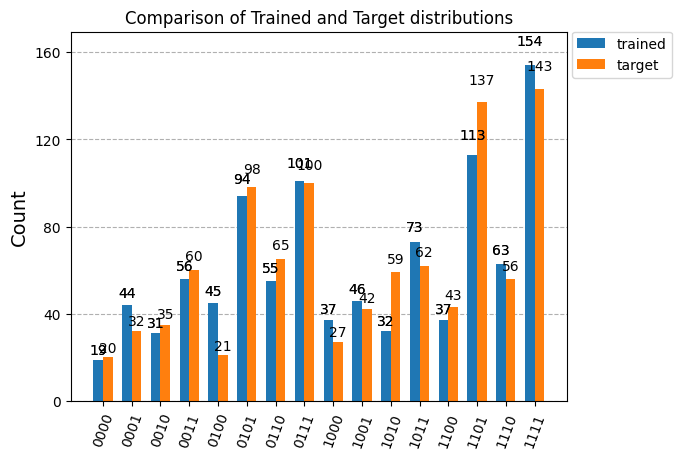

In [ ]:
from qiskit.visualization import plot_histogram

plot_histogram([final_hist, sequence],
               legend=['trained', 'target'],
               title='Comparison of Trained and Target distributions',
               )

In [ ]:
len([])

0